In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn import preprocessing
import tensorflow as tf
import math
from numpy import asarray
from numpy import save
from numpy import load
from keras.models import Sequential
from keras.layers import Dense,Conv1D, Conv2D, MaxPooling2D, Dropout, Flatten, Input, MaxPooling1D
from sklearn.preprocessing import StandardScaler
import os
import tempfile
from tensorflow import keras
from keras.optimizers import RMSprop
from keras.utils import to_categorical
import matplotlib as mpl
import sklearn

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
EPOCHS = 20
BATCH_SIZE = 16
mpl.rcParams['figure.figsize'] = (15, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load dataset.
dict_train = np.load('noAnno_train_14_nucleotide_array_no_cluster0.npz')
x_train = np.stack(dict_train['arr_0'], axis=0)
y_flt_train = np.load('noAnno_train_14_nucleotide_labels_no_cluster0.npy')
y_train = y_flt_train.astype(int)-1  # Renumber the classes to #cluster-1
y_train_oh = to_categorical(y_train, num_classes=44)  # Make labels into one-hot encode. 

dict_test = np.load('noAnno_test_14_nucleotide_array_no_cluster0.npz')
x_test = np.stack(dict_test['arr_0'], axis=0)
y_flt_test = np.load('noAnno_test_14_nucleotide_labels_no_cluster0.npy')
y_test = y_flt_test.astype(int)-1  # Renumber the classes to #cluster-1
y_test_oh = to_categorical(y_test, num_classes=44)  # Make labels into one-hot encode. 

print('Training features shape:', x_train.shape)
print('Test features shape:', x_test.shape)
print('Training labels shape:', y_train_oh.shape)
print('Test labels shape:', y_test_oh.shape)

Training features shape: (6521, 14, 4)
Test features shape: (3240, 14, 4)
Training labels shape: (6521, 44)
Test labels shape: (3240, 44)


In [3]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

2024-01-09 14:23:51.010000: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-09 14:23:51.010060: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-09 14:23:51.010067: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-09 14:23:51.010561: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-09 14:23:51.010758: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
def make_model1(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = Sequential([
    # The input shape is 14x4
    # This is the first convolution
    Conv1D(16, 3, strides=1, activation='relu',padding='same', #4(possible base)^3(kernal size)=64
                 input_shape=(14, 4),
                 kernel_initializer='he_normal',  
                 bias_initializer='zeros'),
    # MaxPooling1D(pool_size=2, strides=2),
    Dropout(0.2),
    Conv1D(32, 3, strides=1, activation='relu',padding='same', 
                 kernel_initializer='he_normal',
                 bias_initializer='zeros'),
    MaxPooling1D(pool_size=2, strides=2),    
    Dropout(0.2),
    Flatten(),
    #  neuron hidden layer
    Dense(224, activation='relu', bias_initializer=output_bias, kernel_initializer='he_normal'),  #14/2(maxpooling)=7, 32*7 = 224
    Dropout(0.2),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('not GNRA') and 1 for the other ('GNRA')
    Dense(44, activation='softmax', bias_initializer=output_bias, kernel_initializer='glorot_uniform')  #Softmax for multiclass classification problem. Glorot for softmax.
    ])
     
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), #optimizer=RMSprop(lr=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=METRICS)  # Accuracy for classification problems. 
  
  return model

In [5]:
def make_model2(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = Sequential([
    # The input shape is 14x4
    # This is the first convolution
    Conv1D(64, 3, strides=1, activation='relu',padding='same', #4(possible base)^3(kernal size)=64
                 input_shape=(14, 4),
                 kernel_initializer='he_normal',  
                 bias_initializer='zeros'),
    # MaxPooling1D(pool_size=2, strides=2),
    Dropout(0.2),
    Conv1D(32, 3, strides=1, activation='relu',padding='same', 
                 kernel_initializer='he_normal',
                 bias_initializer='zeros'),
    MaxPooling1D(pool_size=2, strides=2),    
    Dropout(0.2),
    Flatten(),
    #  neuron hidden layer
    Dense(224, activation='relu', bias_initializer=output_bias, kernel_initializer='he_normal'),  #8/2(maxpooling)=4, 32*4 = 128
    Dropout(0.2),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('not GNRA') and 1 for the other ('GNRA')
    Dense(44, activation='softmax', bias_initializer=output_bias, kernel_initializer='glorot_uniform')  #Softmax for multiclass classification problem. Glorot for softmax.
    ])
     
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), #optimizer=RMSprop(lr=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=METRICS)  # Accuracy for classification problems. 
  
  return model

In [6]:
def make_model3(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = Sequential([
    # The input shape is 14x4
    # This is the first convolution
    Conv1D(64, 3, strides=1, activation='relu',padding='same', #4(possible base)^3(kernal size)=64
                 input_shape=(14, 4),
                 kernel_initializer='he_normal',  
                 bias_initializer='zeros'),
    # MaxPooling1D(pool_size=2, strides=2),
    Dropout(0.2),
    Conv1D(128, 3, strides=1, activation='relu',padding='same', 
                 kernel_initializer='he_normal',
                 bias_initializer='zeros'),
    # MaxPooling1D(pool_size=2, strides=2),    
    Dropout(0.2),
    Flatten(),
    #  neuron hidden layer
    Dense(224, activation='relu', bias_initializer=output_bias, kernel_initializer='he_normal'),  #8/2(maxpooling)=4, 32*4 = 128
    Dropout(0.2),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('not GNRA') and 1 for the other ('GNRA')
    Dense(44, activation='softmax', bias_initializer=output_bias, kernel_initializer='glorot_uniform')  #Softmax for multiclass classification problem. Glorot for softmax.
    ])
     
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), #optimizer=RMSprop(lr=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=METRICS)  # Accuracy for classification problems. 
  
  return model

In [7]:
# Plot loss and accuracy.
def plot_metrics(history1, history2, history3):
  metrics = ['loss', 'accuracy']
  plt.rcParams['font.size'] = '16'
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(1,2,n+1)
    plt.plot(history1.epoch, history1.history[metric], color=colors[0], label='Conf1.2_Train')
    plt.plot(history1.epoch, history1.history['val_' + metric],
             color=colors[0], linestyle="--", label='Conf1.2_Test')
    plt.plot(history2.epoch, history2.history[metric], color=colors[1], label='Conf2.2_Train')
    plt.plot(history2.epoch, history2.history['val_' + metric],
             color=colors[1], linestyle="--", label='Conf2.2_Test')
    plt.plot(history3.epoch, history3.history[metric], color=colors[2], label='Conf3.3_Train')
    plt.plot(history3.epoch, history3.history['val_' + metric],
             color=colors[2], linestyle="--", label='Conf3.3_Test')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'accuracy':
      plt.ylim([0,1])
    else:
      plt.ylim([0,1])

    plt.legend();

In [8]:
# Plot confusion matrix
def plot_cm_multiclass(labels, predictions):
    unique_labels = sorted(set(labels))  # Get unique labels and sort them
    cm = confusion_matrix(labels, np.argmax(predictions, axis=1), labels=unique_labels)
    
    plt.figure(figsize=(20, 10))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=unique_labels, yticklabels=unique_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    for text in ax.texts:
        text.set_fontsize(8)
    plt.show()
    
    for label in unique_labels:
        idx = unique_labels.index(label)
        true_positive = cm[idx, idx]
        false_positive = np.sum(cm[:, idx]) - true_positive
        false_negative = np.sum(cm[idx, :]) - true_positive
        true_negative = np.sum(cm) - true_positive - false_positive - false_negative
        
        print(f"Label {label}:")
        print('True Positives:', true_positive)
        print('False Positives:', false_positive)
        print('False Negatives:', false_negative)
        print('True Negatives:', true_negative)
        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        print('Precision:', precision)
        print('Recall:', recall)
        print('--------------------')

In [25]:
# Plot ROC curve.
def plot_roc(name, labels, predictions, **kwargs):
    n_classes = predictions.shape[1]
    fpr = dict()
    tpr = dict()
    
    line_styles = ['-', '--', '-.', ':']
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black']
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(labels == i, predictions[:, i])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        linestyle = line_styles[i % len(line_styles)]
        color = colors[i % len(colors)]
        plt.plot(100 * fpr[i], 100 * tpr[i], label=f'{name} (Class {i})', linewidth=2, linestyle=linestyle, color=color, **kwargs)

    plt.xlabel('False Positive Rate (%)')
    plt.ylabel('True Positive Rate (%)')
    plt.xlim([-5, 100])
    plt.ylim([0, 105])
    plt.grid(True)
    plt.legend(loc='center left', fontsize='small', bbox_to_anchor=(1.05, 0.5), title='Legend', title_fontsize='medium', ncol=3)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.subplots_adjust(right=0.7)  # Adjust the figure size to accommodate the legend
    plt.show()

In [27]:
# Plot precision-recall curve
def plot_prc(name, labels, predictions):
    n_classes = predictions.shape[1]
    
    line_styles = ['-', '--', '-.', ':']
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black']
    
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        linestyle = line_styles[i % len(line_styles)]
        color = colors[i % len(colors)]
    
        precision, recall, _ = sklearn.metrics.precision_recall_curve(labels == i, predictions[:, i])
        plt.plot(recall, precision, label=f'{name} (Class {i})', linewidth=2, linestyle=linestyle, color=color)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize='small', title='Legend', title_fontsize='medium', ncol=3)
    plt.gca().set_aspect('equal')
    plt.show()

In [11]:
# retrain with class weights
# The sum of the weights of all examples stays the same.
y_integers = np.argmax(y_train_oh, axis=1)
class_weights = np.round(class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers), 2)
d_class_weights = dict(enumerate(class_weights))
  
print(d_class_weights)

{0: 0.04, 1: 0.38, 2: 0.71, 3: 0.97, 4: 0.82, 5: 1.03, 6: 0.99, 7: 0.99, 8: 1.58, 9: 1.2, 10: 1.67, 11: 1.29, 12: 1.43, 13: 1.88, 14: 1.18, 15: 1.61, 16: 1.58, 17: 1.65, 18: 1.9, 19: 2.35, 20: 2.8, 21: 2.51, 22: 148.2, 23: 5.11, 24: 8.72, 25: 7.41, 26: 148.2, 27: 18.53, 28: 14.82, 29: 49.4, 30: 29.64, 31: 5.7, 32: 13.47, 33: 24.7, 34: 148.2, 35: 74.1, 36: 148.2, 37: 148.2, 38: 74.1, 39: 10.59, 40: 148.2, 41: 24.7, 42: 18.53, 43: 148.2}


In [12]:
# Train the CNN model on the training set and evaluate by test set.
weighted_model1 = make_model1()
#weighted_model.load_weights(initial_weights)

# model.fit trains the model for a fixed number of epochs (iterations on a dataset).
weighted_history1 = weighted_model1.fit(
    x_train,
    y_train_oh, 
    validation_data = (x_test, y_test_oh),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

    # The class weights go here
    class_weight=d_class_weights)

Epoch 1/20


2024-01-09 14:23:58.046827: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-01-09 14:23:58.446189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


408/408 [==============================] - ETA: 0s - loss: 3.6164 - tp: 571.0000 - fp: 189.0000 - tn: 280214.0000 - fn: 5950.0000 - accuracy: 0.2702 - precision: 0.7513 - recall: 0.0876 - auc: 0.8535 - prc: 0.2548

2024-01-09 14:24:05.481418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


408/408 [==============================] - 9s 21ms/step - loss: 3.6164 - tp: 571.0000 - fp: 189.0000 - tn: 280214.0000 - fn: 5950.0000 - accuracy: 0.2702 - precision: 0.7513 - recall: 0.0876 - auc: 0.8535 - prc: 0.2548 - val_loss: 1.6659 - val_tp: 886.0000 - val_fp: 72.0000 - val_tn: 139248.0000 - val_fn: 2354.0000 - val_accuracy: 0.5642 - val_precision: 0.9248 - val_recall: 0.2735 - val_auc: 0.9824 - val_prc: 0.6365
Epoch 2/20
408/408 [==============================] - 10s 24ms/step - loss: 1.9658 - tp: 1869.0000 - fp: 609.0000 - tn: 279794.0000 - fn: 4652.0000 - accuracy: 0.4771 - precision: 0.7542 - recall: 0.2866 - auc: 0.9495 - prc: 0.5086 - val_loss: 0.9614 - val_tp: 1275.0000 - val_fp: 90.0000 - val_tn: 139230.0000 - val_fn: 1965.0000 - val_accuracy: 0.8136 - val_precision: 0.9341 - val_recall: 0.3935 - val_auc: 0.9954 - val_prc: 0.8759
Epoch 3/20
408/408 [==============================] - 9s 22ms/step - loss: 1.1170 - tp: 2934.0000 - fp: 746.0000 - tn: 279657.0000 - fn: 3587.00

In [13]:
# Train the CNN model on the training set and evaluate by test set.
weighted_model2 = make_model2()
#weighted_model.load_weights(initial_weights)

# model.fit trains the model for a fixed number of epochs (iterations on a dataset).
weighted_history2 = weighted_model2.fit(
    x_train,
    y_train_oh, 
    validation_data = (x_test, y_test_oh),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

    # The class weights go here
    class_weight=d_class_weights)

Epoch 1/20


2024-01-09 14:26:47.718319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


408/408 [==============================] - ETA: 0s - loss: 3.1307 - tp: 4029.0000 - fp: 400.0000 - tn: 419323.0000 - fn: 5732.0000 - accuracy: 0.5590 - precision: 0.9097 - recall: 0.4128 - auc: 0.9507 - prc: 0.6369

2024-01-09 14:26:54.360782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


408/408 [==============================] - 9s 21ms/step - loss: 3.1307 - tp: 4029.0000 - fp: 400.0000 - tn: 419323.0000 - fn: 5732.0000 - accuracy: 0.5590 - precision: 0.9097 - recall: 0.4128 - auc: 0.9507 - prc: 0.6369 - val_loss: 1.5020 - val_tp: 797.0000 - val_fp: 87.0000 - val_tn: 139233.0000 - val_fn: 2443.0000 - val_accuracy: 0.6975 - val_precision: 0.9016 - val_recall: 0.2460 - val_auc: 0.9867 - val_prc: 0.7229
Epoch 2/20
408/408 [==============================] - 9s 21ms/step - loss: 1.6090 - tp: 2395.0000 - fp: 469.0000 - tn: 279934.0000 - fn: 4126.0000 - accuracy: 0.5965 - precision: 0.8362 - recall: 0.3673 - auc: 0.9714 - prc: 0.6581 - val_loss: 0.9047 - val_tp: 1486.0000 - val_fp: 132.0000 - val_tn: 139188.0000 - val_fn: 1754.0000 - val_accuracy: 0.7756 - val_precision: 0.9184 - val_recall: 0.4586 - val_auc: 0.9940 - val_prc: 0.8585
Epoch 3/20
408/408 [==============================] - 9s 21ms/step - loss: 0.7617 - tp: 3557.0000 - fp: 723.0000 - tn: 279680.0000 - fn: 2964.0

In [14]:
# Train the CNN model on the training set and evaluate by test set.
weighted_model3 = make_model3()
#weighted_model.load_weights(initial_weights)

# model.fit trains the model for a fixed number of epochs (iterations on a dataset).
weighted_history3 = weighted_model3.fit(
    x_train,
    y_train_oh, 
    validation_data = (x_test, y_test_oh),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

    # The class weights go here
    class_weight=d_class_weights)

Epoch 1/20


2024-01-09 14:29:32.692193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


408/408 [==============================] - ETA: 0s - loss: 3.1877 - tp: 5010.0000 - fp: 1252.0000 - tn: 418471.0000 - fn: 4751.0000 - accuracy: 0.6190 - precision: 0.8001 - recall: 0.5133 - auc: 0.9649 - prc: 0.7050

2024-01-09 14:29:39.598501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


408/408 [==============================] - 9s 22ms/step - loss: 3.1877 - tp: 5010.0000 - fp: 1252.0000 - tn: 418471.0000 - fn: 4751.0000 - accuracy: 0.6190 - precision: 0.8001 - recall: 0.5133 - auc: 0.9649 - prc: 0.7050 - val_loss: 0.7843 - val_tp: 1823.0000 - val_fp: 116.0000 - val_tn: 139204.0000 - val_fn: 1417.0000 - val_accuracy: 0.8009 - val_precision: 0.9402 - val_recall: 0.5627 - val_auc: 0.9952 - val_prc: 0.8913
Epoch 2/20
408/408 [==============================] - 8s 20ms/step - loss: 1.1541 - tp: 3508.0000 - fp: 1393.0000 - tn: 279010.0000 - fn: 3013.0000 - accuracy: 0.6206 - precision: 0.7158 - recall: 0.5380 - auc: 0.9552 - prc: 0.6614 - val_loss: 0.7024 - val_tp: 2147.0000 - val_fp: 219.0000 - val_tn: 139101.0000 - val_fn: 1093.0000 - val_accuracy: 0.8472 - val_precision: 0.9074 - val_recall: 0.6627 - val_auc: 0.9925 - val_prc: 0.8839
Epoch 3/20
408/408 [==============================] - 8s 21ms/step - loss: 0.4624 - tp: 4708.0000 - fp: 870.0000 - tn: 279533.0000 - fn: 18

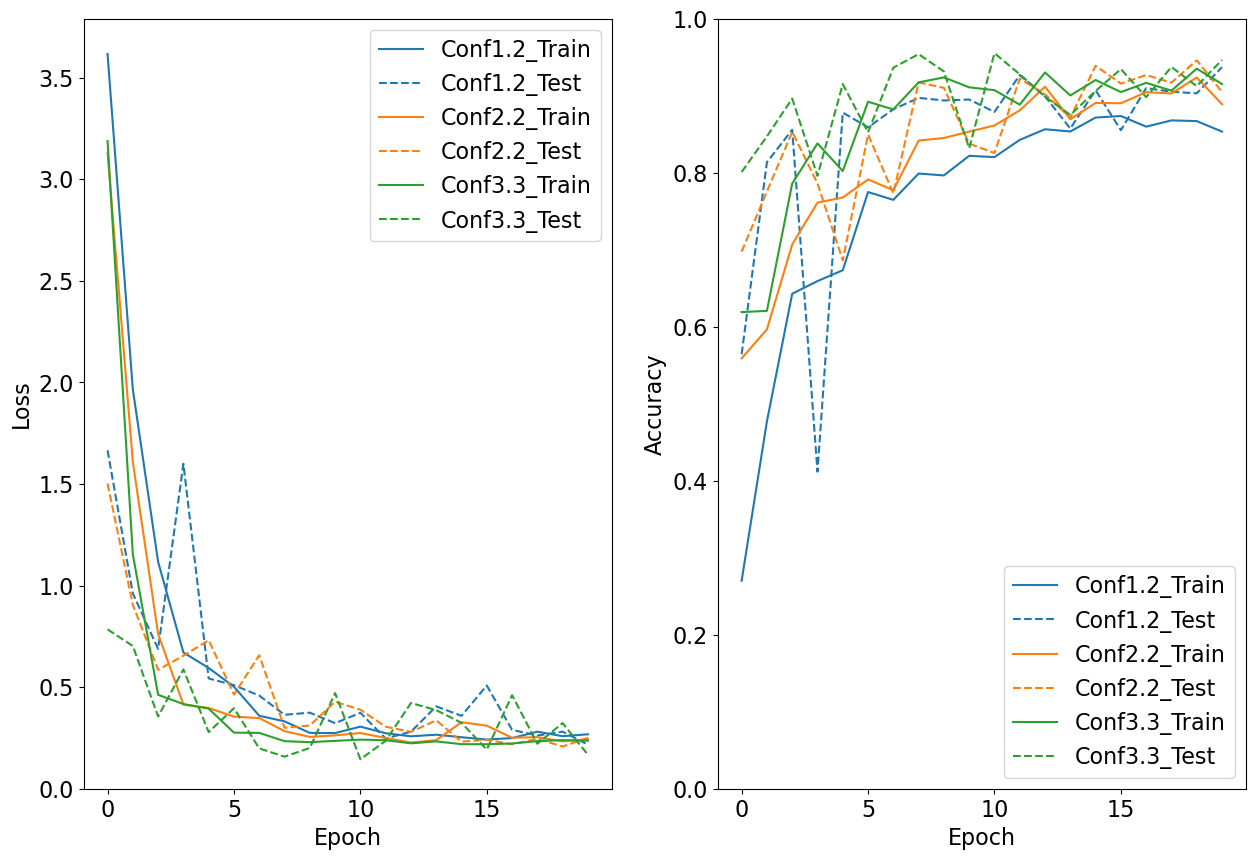

In [15]:
plot_metrics(weighted_history1, weighted_history2, weighted_history3)

In [16]:
# Model.predict gives the predicted output. 
train_predictions_weighted1 = weighted_model1.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_weighted1 = weighted_model1.predict(x_test, batch_size=BATCH_SIZE)

 72/408 [====>.........................] - ETA: 0s

2024-01-09 14:32:24.557698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 0s 2ms/step


In [17]:
# Model.predict gives the predicted output. 
train_predictions_weighted2 = weighted_model2.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_weighted2 = weighted_model2.predict(x_test, batch_size=BATCH_SIZE)

 86/408 [=====>........................] - ETA: 0s

2024-01-09 14:32:25.907090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 0s 2ms/step


In [18]:
# Model.predict gives the predicted output. 
train_predictions_weighted3 = weighted_model3.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_weighted3 = weighted_model3.predict(x_test, batch_size=BATCH_SIZE)

 87/408 [=====>........................] - ETA: 0s

2024-01-09 14:32:27.170843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 0s 2ms/step


loss :  0.21712711453437805
tp :  2982.0
fp :  170.0
tn :  139150.0
fn :  258.0
accuracy :  0.9370370507240295
precision :  0.9460659623146057
recall :  0.9203703999519348
auc :  0.9971383810043335
prc :  0.9744139313697815



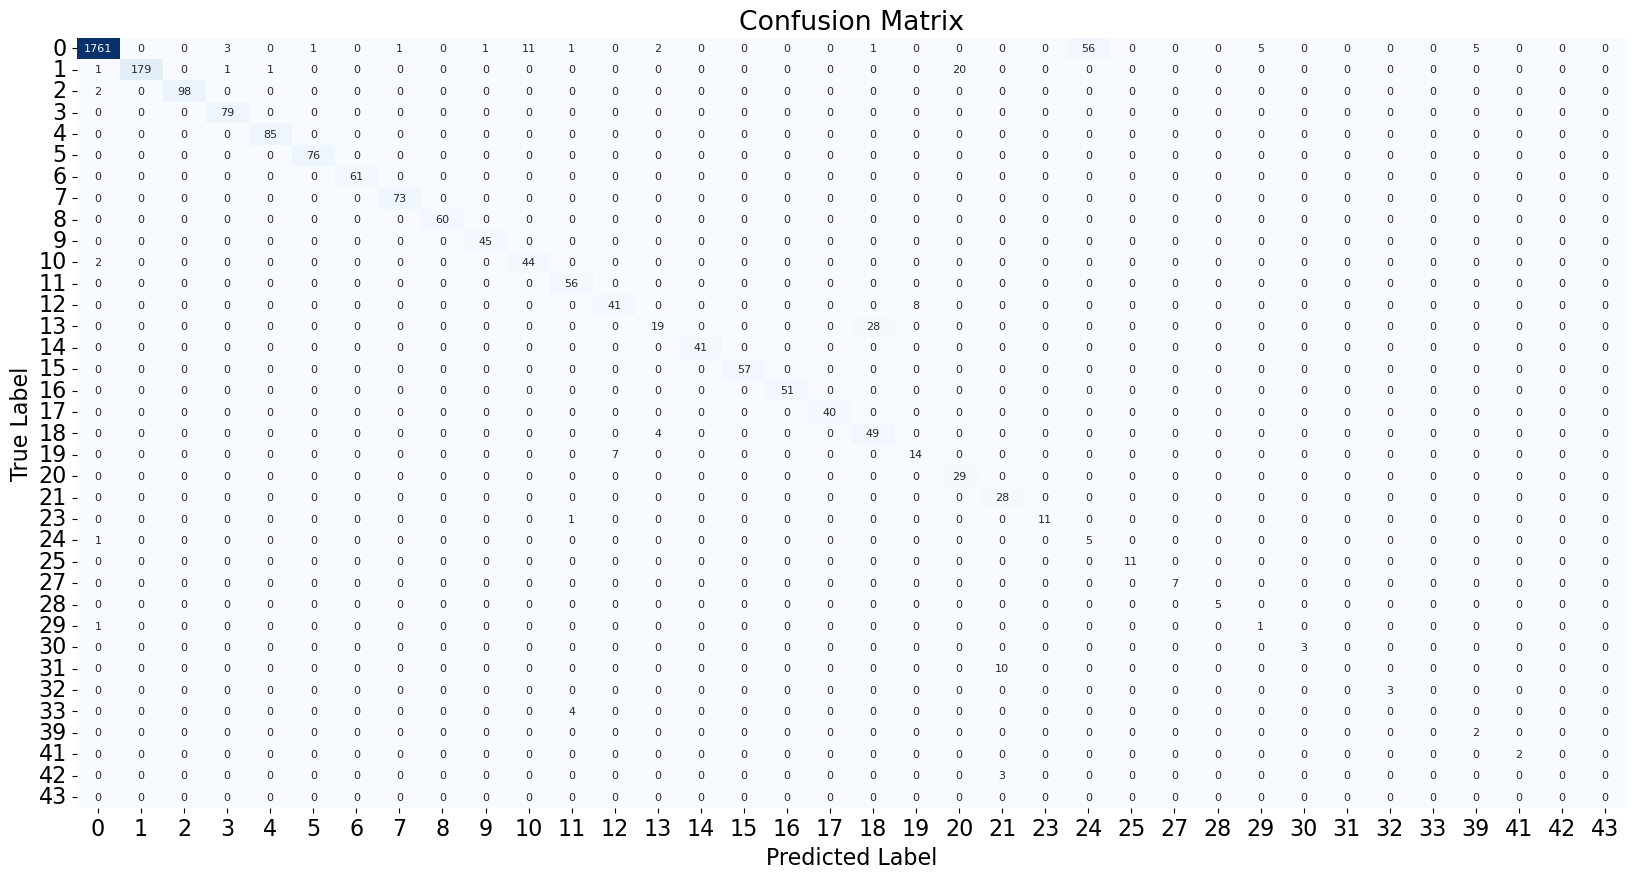

Label 0:
True Positives: 1761
False Positives: 7
False Negatives: 87
True Negatives: 1362
Precision: 0.9960407239819005
Recall: 0.952922077922078
--------------------
Label 1:
True Positives: 179
False Positives: 0
False Negatives: 23
True Negatives: 3015
Precision: 1.0
Recall: 0.8861386138613861
--------------------
Label 2:
True Positives: 98
False Positives: 0
False Negatives: 2
True Negatives: 3117
Precision: 1.0
Recall: 0.98
--------------------
Label 3:
True Positives: 79
False Positives: 4
False Negatives: 0
True Negatives: 3134
Precision: 0.9518072289156626
Recall: 1.0
--------------------
Label 4:
True Positives: 85
False Positives: 1
False Negatives: 0
True Negatives: 3131
Precision: 0.9883720930232558
Recall: 1.0
--------------------
Label 5:
True Positives: 76
False Positives: 1
False Negatives: 0
True Negatives: 3140
Precision: 0.987012987012987
Recall: 1.0
--------------------
Label 6:
True Positives: 61
False Positives: 0
False Negatives: 0
True Negatives: 3156
Precision

In [19]:
# Results of test data set. 
# model.evaluate returns the loss value & metrics values for the model in test mode (the model is already trained).
weighted_results = weighted_model1.evaluate(x_test, y_test_oh,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model1.metrics_names, weighted_results):
  print(name, ': ', value)
print()


plot_cm_multiclass(y_test, test_predictions_weighted1)

loss :  0.2504872977733612
tp :  2873.0
fp :  278.0
tn :  139042.0
fn :  367.0
accuracy :  0.9049383401870728
precision :  0.9117740392684937
recall :  0.8867284059524536
auc :  0.9959429502487183
prc :  0.9661682844161987



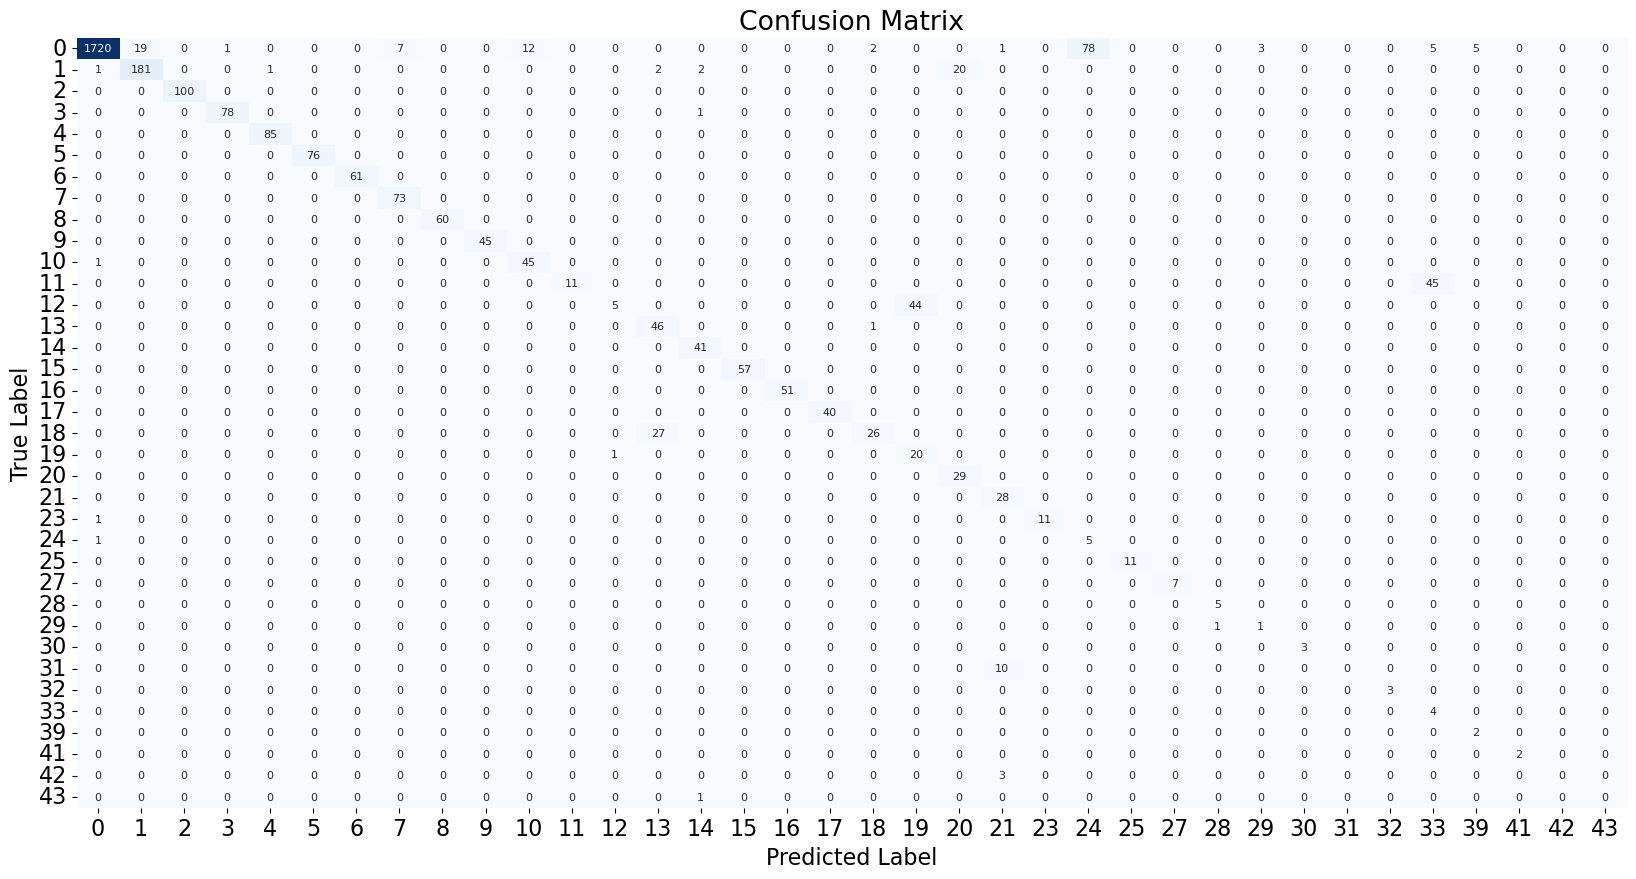

Label 0:
True Positives: 1720
False Positives: 4
False Negatives: 133
True Negatives: 1371
Precision: 0.9976798143851509
Recall: 0.9282245008094981
--------------------
Label 1:
True Positives: 181
False Positives: 19
False Negatives: 26
True Negatives: 3002
Precision: 0.905
Recall: 0.8743961352657005
--------------------
Label 2:
True Positives: 100
False Positives: 0
False Negatives: 0
True Negatives: 3128
Precision: 1.0
Recall: 1.0
--------------------
Label 3:
True Positives: 78
False Positives: 1
False Negatives: 1
True Negatives: 3148
Precision: 0.9873417721518988
Recall: 0.9873417721518988
--------------------
Label 4:
True Positives: 85
False Positives: 1
False Negatives: 0
True Negatives: 3142
Precision: 0.9883720930232558
Recall: 1.0
--------------------
Label 5:
True Positives: 76
False Positives: 0
False Negatives: 0
True Negatives: 3152
Precision: 1.0
Recall: 1.0
--------------------
Label 6:
True Positives: 61
False Positives: 0
False Negatives: 0
True Negatives: 3167
Pre

In [20]:
# Results of test data set. 
# model.evaluate returns the loss value & metrics values for the model in test mode (the model is already trained).
weighted_results = weighted_model2.evaluate(x_test, y_test_oh,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model2.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm_multiclass(y_test, test_predictions_weighted2)

loss :  0.1667356640100479
tp :  3014.0
fp :  118.0
tn :  139202.0
fn :  226.0
accuracy :  0.9466049671173096
precision :  0.9623244404792786
recall :  0.9302469491958618
auc :  0.9975224733352661
prc :  0.982715368270874



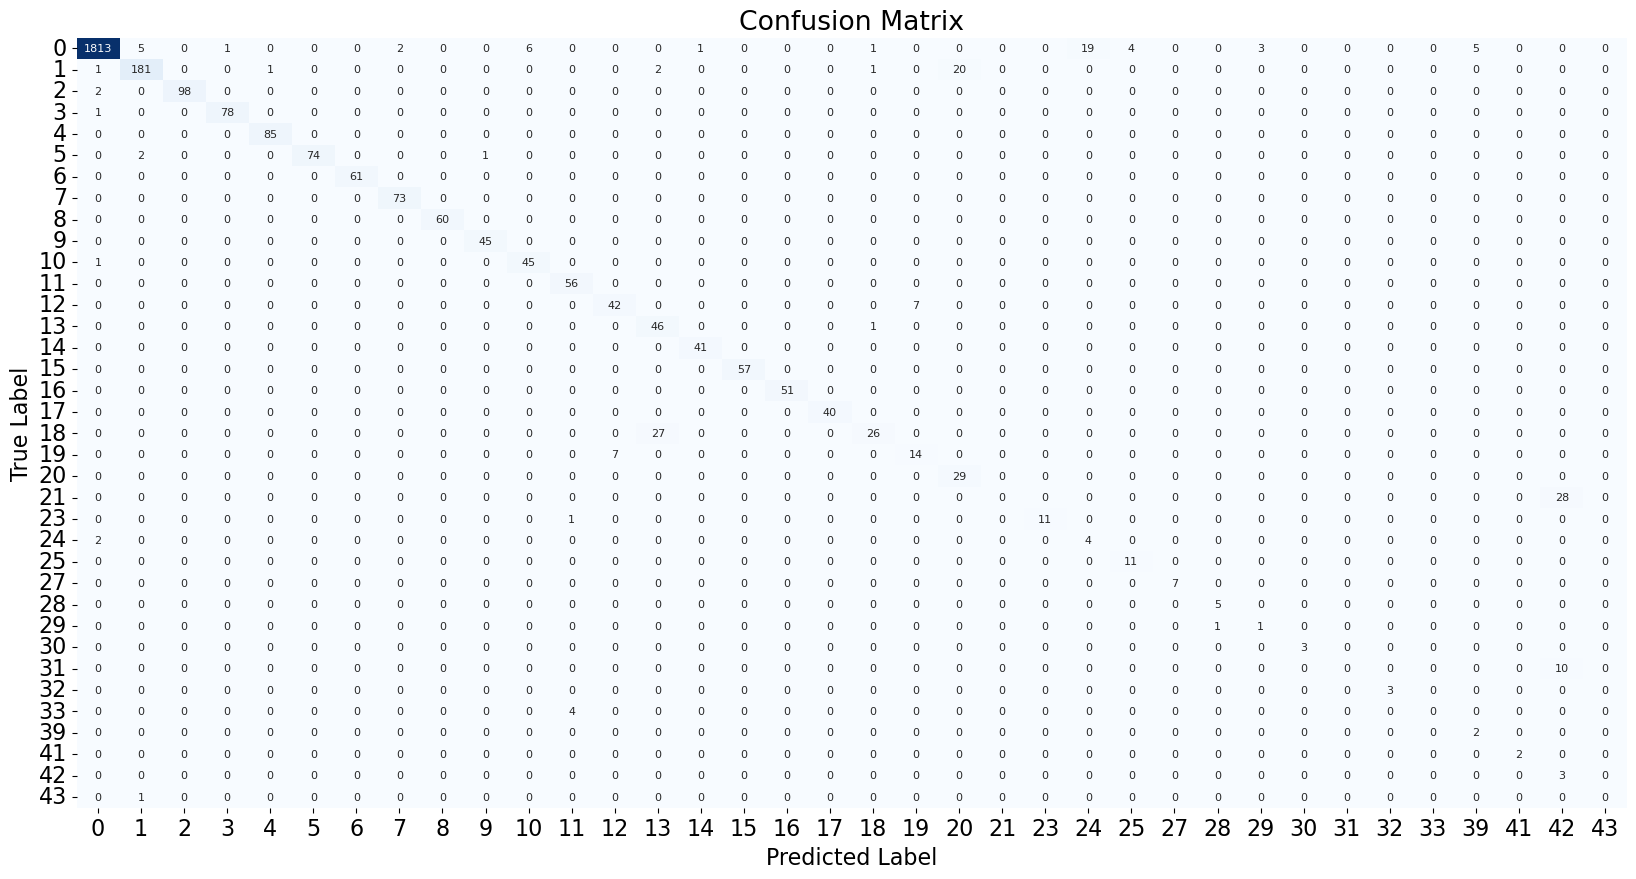

Label 0:
True Positives: 1813
False Positives: 7
False Negatives: 47
True Negatives: 1368
Precision: 0.9961538461538462
Recall: 0.9747311827956989
--------------------
Label 1:
True Positives: 181
False Positives: 8
False Negatives: 25
True Negatives: 3021
Precision: 0.9576719576719577
Recall: 0.8786407766990292
--------------------
Label 2:
True Positives: 98
False Positives: 0
False Negatives: 2
True Negatives: 3135
Precision: 1.0
Recall: 0.98
--------------------
Label 3:
True Positives: 78
False Positives: 1
False Negatives: 1
True Negatives: 3155
Precision: 0.9873417721518988
Recall: 0.9873417721518988
--------------------
Label 4:
True Positives: 85
False Positives: 1
False Negatives: 0
True Negatives: 3149
Precision: 0.9883720930232558
Recall: 1.0
--------------------
Label 5:
True Positives: 74
False Positives: 0
False Negatives: 3
True Negatives: 3158
Precision: 1.0
Recall: 0.961038961038961
--------------------
Label 6:
True Positives: 61
False Positives: 0
False Negatives: 0

In [21]:
# Results of test data set. 
# model.evaluate returns the loss value & metrics values for the model in test mode (the model is already trained).
weighted_results = weighted_model3.evaluate(x_test, y_test_oh,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model3.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm_multiclass(y_test, test_predictions_weighted3)

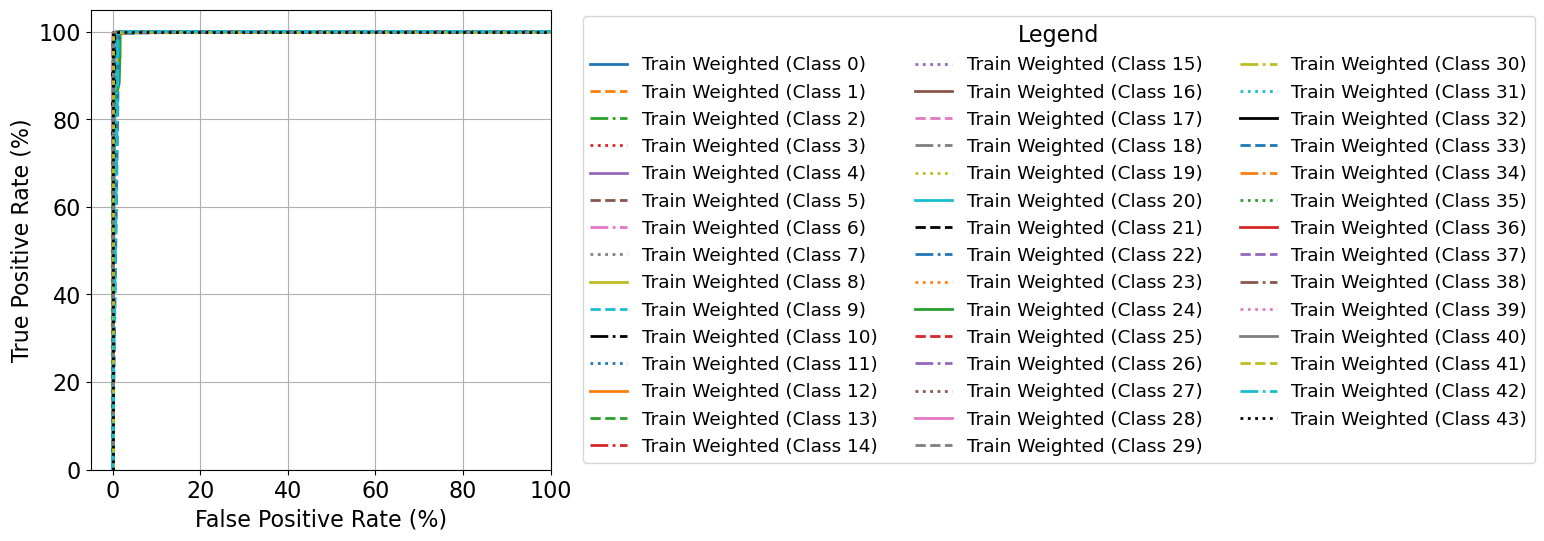

/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positiv

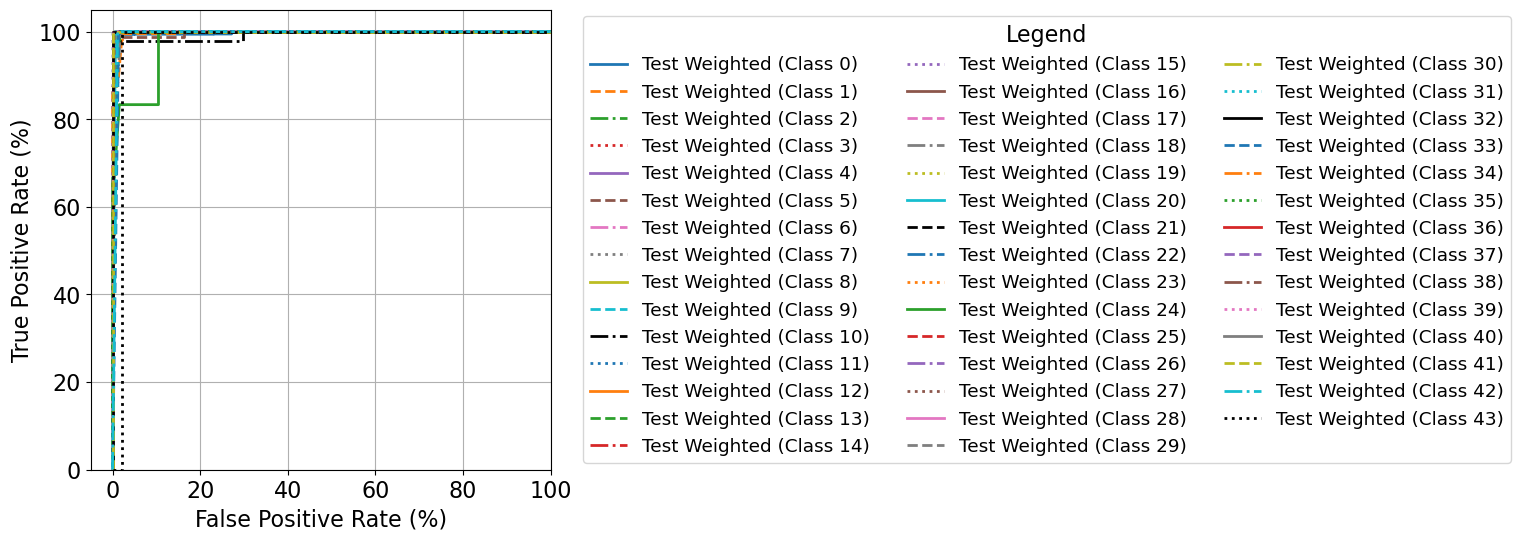

In [26]:
plot_roc("Train Weighted", y_train, train_predictions_weighted1)
plot_roc("Test Weighted", y_test, test_predictions_weighted1)

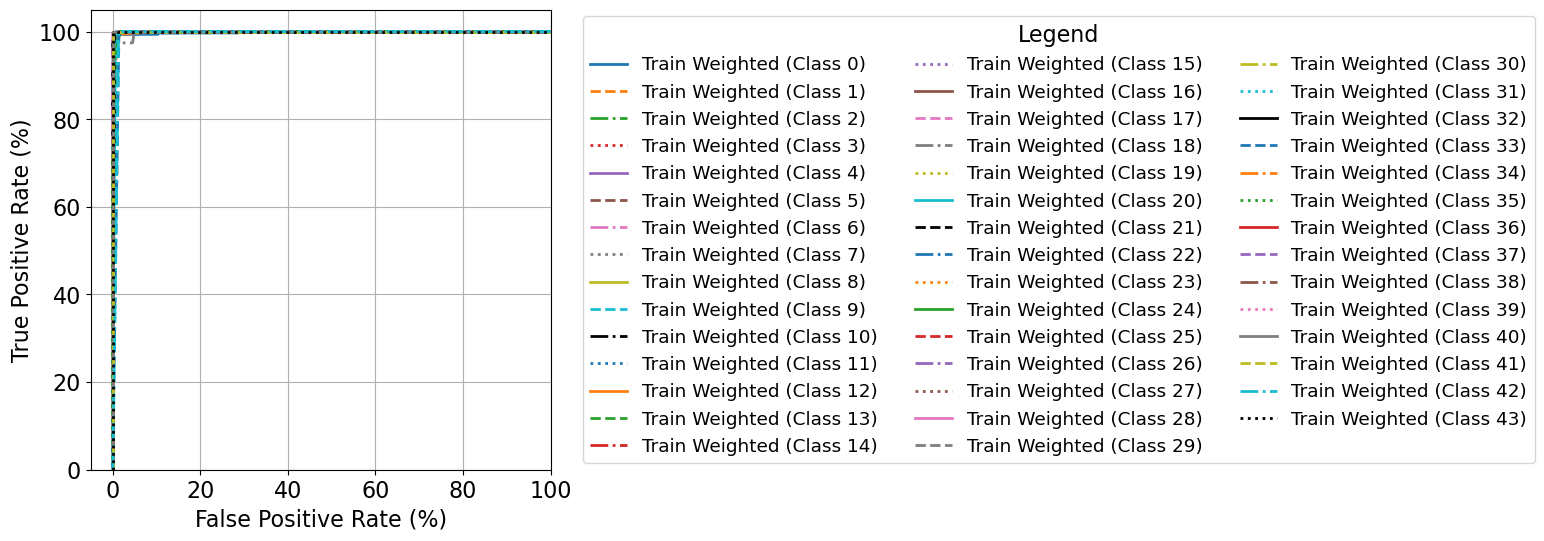

/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positiv

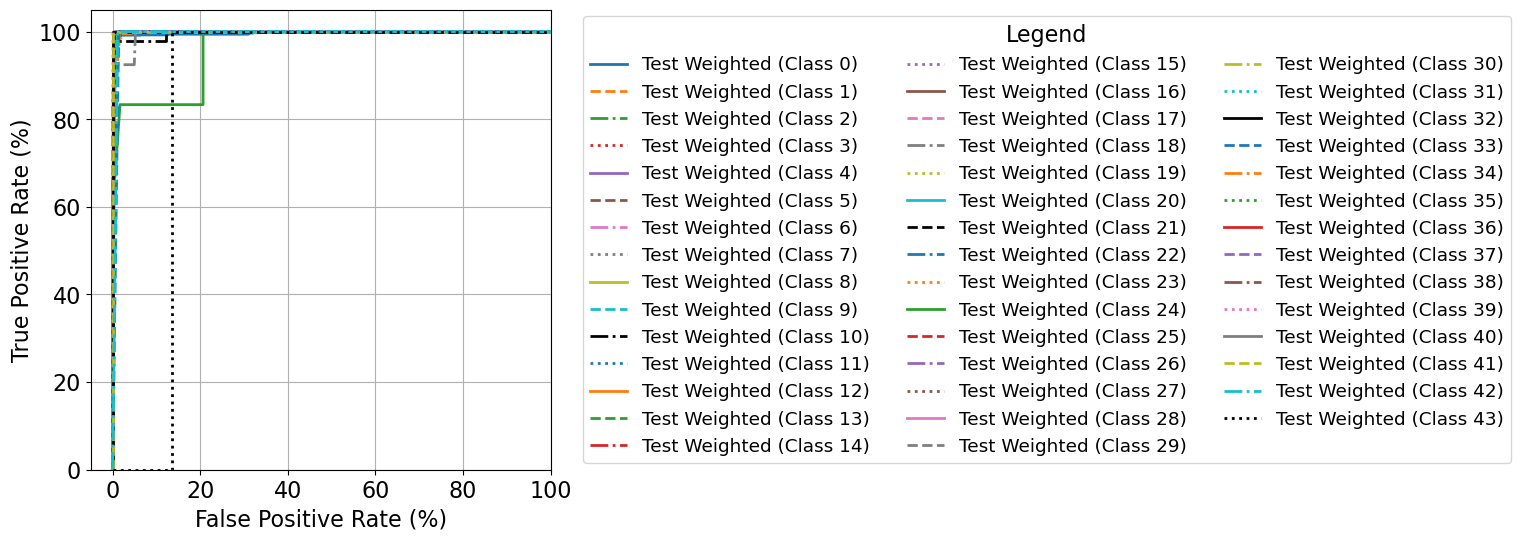

In [28]:
plot_roc("Train Weighted", y_train, train_predictions_weighted2)
plot_roc("Test Weighted", y_test, test_predictions_weighted2)

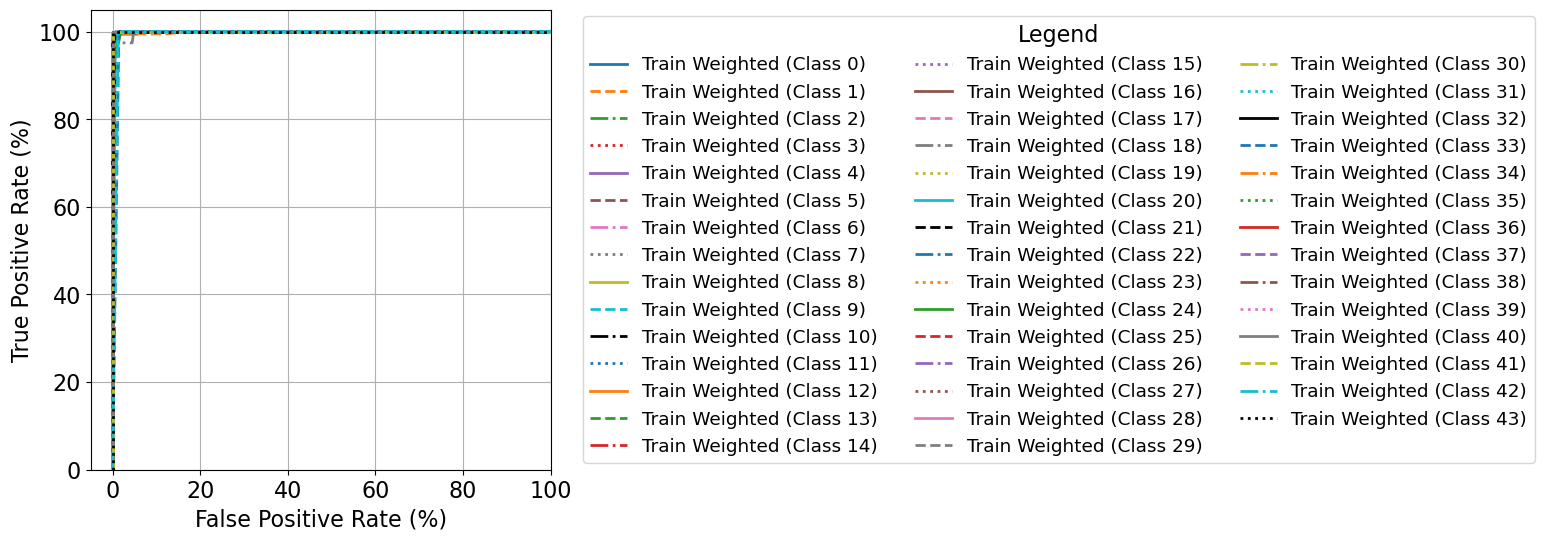

/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positiv

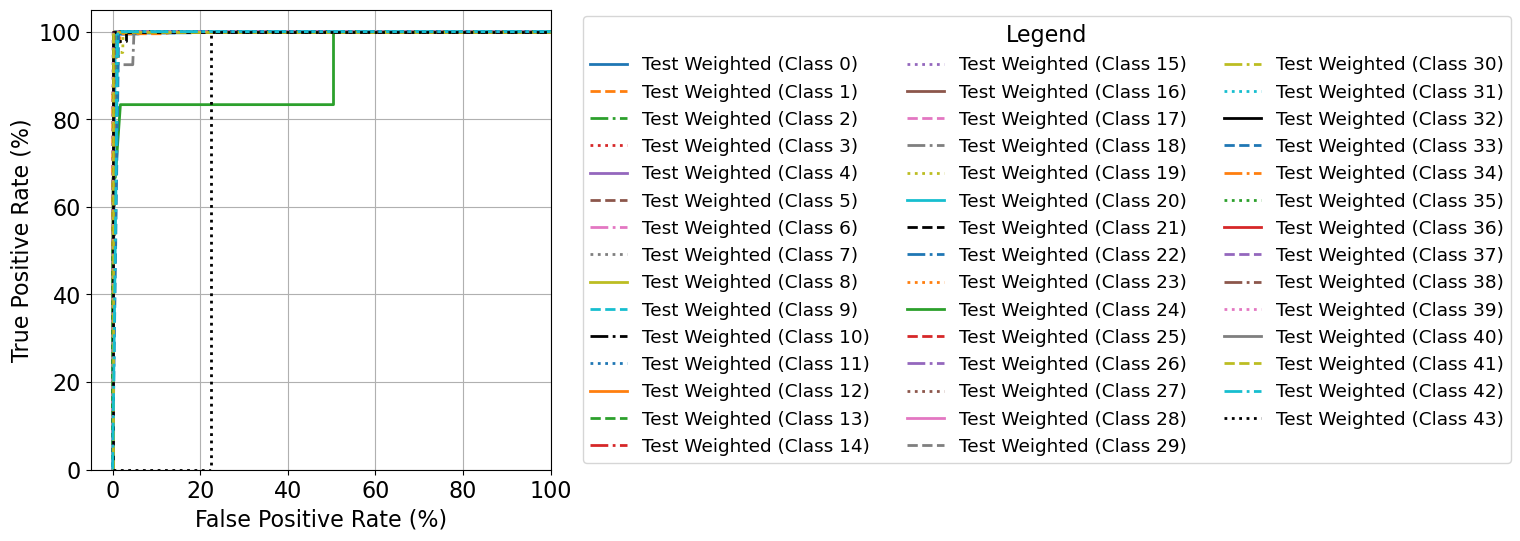

In [29]:
plot_roc("Train Weighted", y_train, train_predictions_weighted3)
plot_roc("Test Weighted", y_test, test_predictions_weighted3)

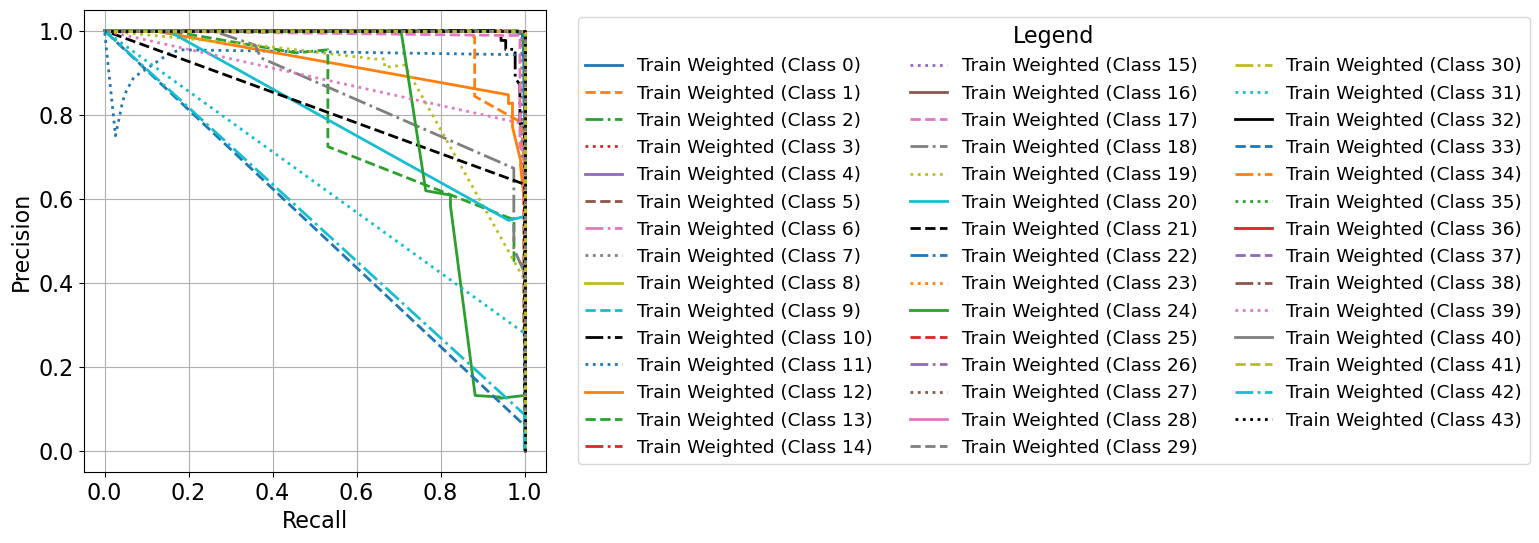

/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one fo

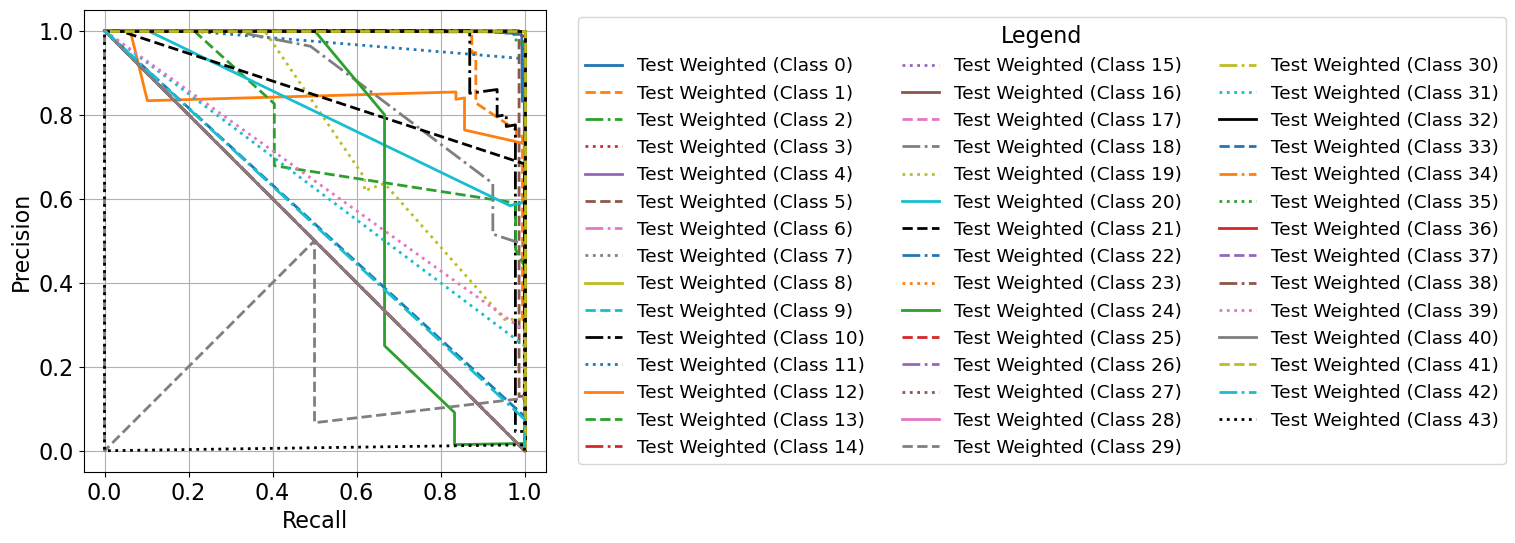

In [30]:
plot_prc("Train Weighted", y_train, train_predictions_weighted1)
plot_prc("Test Weighted", y_test, test_predictions_weighted1)

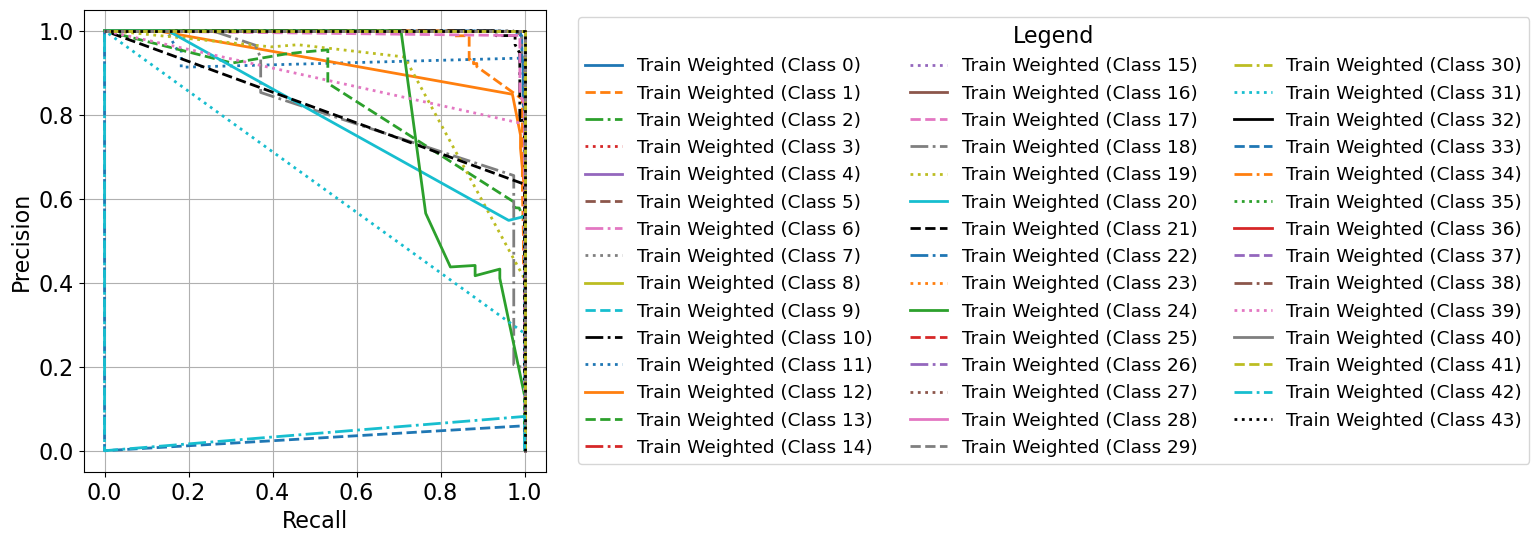

/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one fo

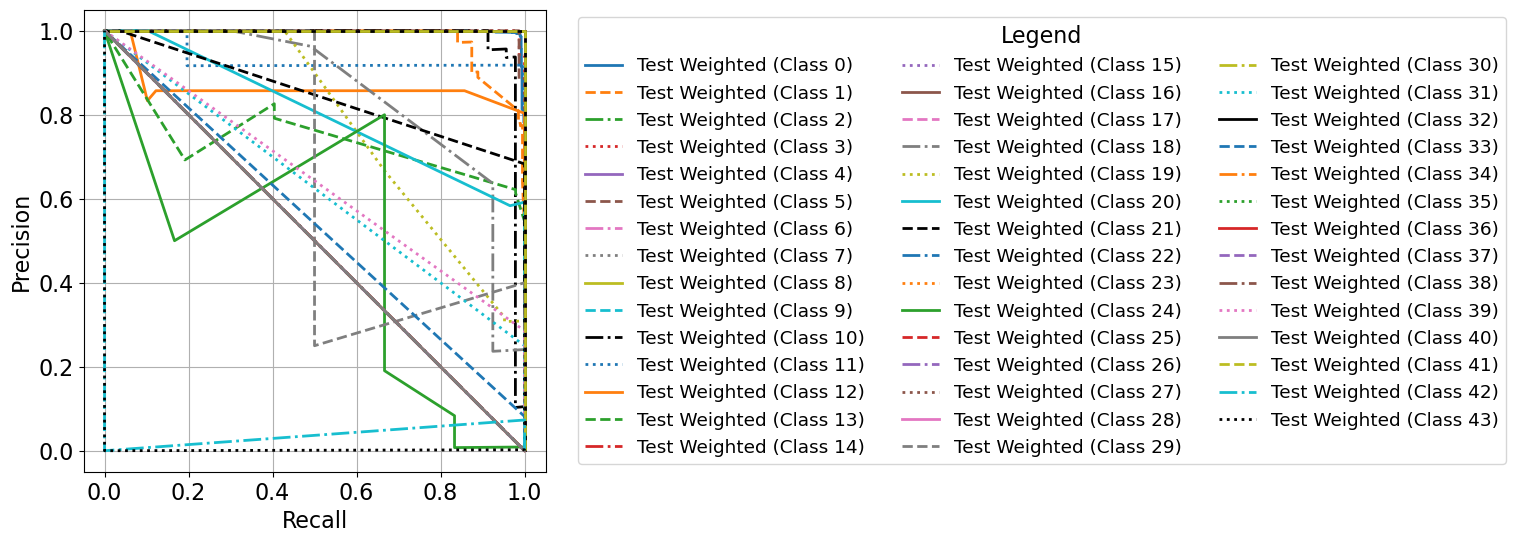

In [31]:
plot_prc("Train Weighted", y_train, train_predictions_weighted2)
plot_prc("Test Weighted", y_test, test_predictions_weighted2)

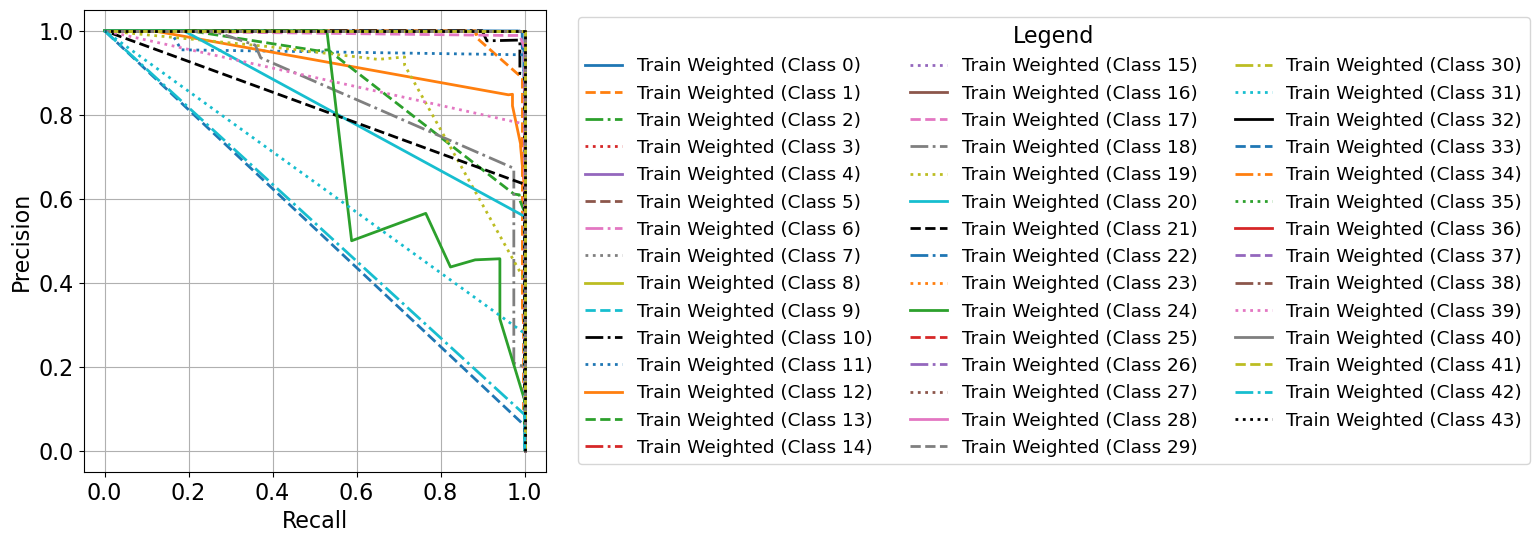

/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one fo

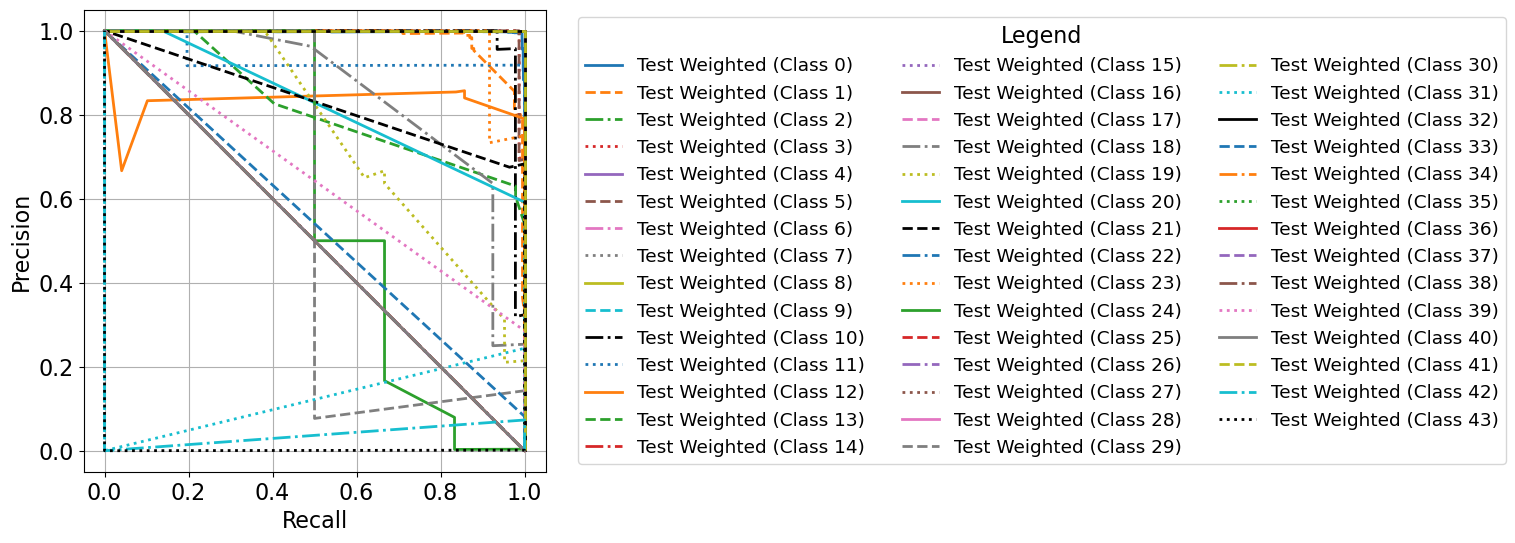

In [32]:
plot_prc("Train Weighted", y_train, train_predictions_weighted3)
plot_prc("Test Weighted", y_test, test_predictions_weighted3)